# Testing Model on TSPLib

In this notebook, we will test the trained model's performance on the TSPLib benchmark. 

[TSPLib](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/) is a collection of instances related to the TSP, which is a classic optimization challenge in the field of logistics and transportation. 

<a href="https://colab.research.google.com/github/ai4co/rl4co/blob/main/examples/datasets/1-test-on-tsplib.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

## Installation

Uncomment the following line to install the package from PyPI. Remember to choose a GPU runtime for faster training!

> Note: You may need to restart the runtime in Colab after this


In [3]:
# !pip install rl4co
# !pip install tsplib95

## NOTE: to install latest version from Github (may be unstable) install from source instead:
# !pip install git+https://github.com/ai4co/rl4co.git

## Imports

In [4]:
%load_ext autoreload
%autoreload 2

import torch
from tensordict import TensorDict

from rl4co.envs import TSPEnv
from rl4co.models.zoo.am import AttentionModelPolicy
from rl4co.models.rl import REINFORCE
from rl4co.utils.trainer import RL4COTrainer


### Utils: download and load TSPLib instances in RL4CO

In [5]:
import requests, tarfile, os, gzip, shutil
from tqdm.auto import tqdm
from tsplib95.loaders import load_problem, load_solution

def download_and_extract_tsplib(url, directory="tsplib", delete_after_unzip=True):
    os.makedirs(directory, exist_ok=True)
    
    # Download with progress bar
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total_size = int(r.headers.get('content-length', 0))
        with open("tsplib.tar.gz", 'wb') as f, tqdm(total=total_size, unit='B', unit_scale=True) as pbar:
            for chunk in r.iter_content(8192):
                f.write(chunk)
                pbar.update(len(chunk))

    # Extract tar.gz
    with tarfile.open("tsplib.tar.gz", 'r:gz') as tar:
        tar.extractall(directory)

    # Decompress .gz files inside directory
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".gz"):
                path = os.path.join(root, file)
                with gzip.open(path, 'rb') as f_in, open(path[:-3], 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
                os.remove(path)

    if delete_after_unzip:
        os.remove("tsplib.tar.gz")

# Download and extract all tsp files under tsplib directory
download_and_extract_tsplib("http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/ALL_tsp.tar.gz")


  0%|          | 0.00/2.02M [00:00<?, ?B/s]

In [6]:
# Load the problem from TSPLib
tsplib_dir = './tsplib'# modify this to the directory of your prepared files
files = os.listdir(tsplib_dir)
problem_files_full = [file for file in files if file.endswith('.tsp')]

# Load the optimal solution files from TSPLib
solution_files = [file for file in files if file.endswith('.opt.tour')] 

In [7]:
problems = []
# Load only problems with solution files
for sol_file in solution_files:
    prob_file = sol_file.replace('.opt.tour', '.tsp')
    problem = load_problem(os.path.join(tsplib_dir, prob_file))

    # NOTE: in some problem files (e.g. hk48), the node coordinates are not available
    # we temporarily skip these problems
    if not len(problem.node_coords):
        continue
    
    node_coords = torch.tensor([v for v in problem.node_coords.values()])
    solution = load_solution(os.path.join(tsplib_dir, sol_file))
    
    problems.append({
        "name": sol_file.replace('.opt.tour', ''),
        "node_coords": node_coords,
        "solution": solution.tours[0],
        "dimension": problem.dimension
    })
    
    
# order by dimension
problems = sorted(problems, key=lambda x: x['dimension'])

/tmp/ipykernel_76573/449557851.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) load_problem. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecated since version 7.0.0.
  problem = load_problem(os.path.join(tsplib_dir, prob_file))
/tmp/ipykernel_76573/449557851.py:13: DeprecationWarning: Call to deprecated function (or staticmethod) load_solution. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecated since version 7.0.0.
  solution = load_solution(os.path.join(tsplib_dir, sol_file))


In [8]:
# Utils function: we will normalize the coordinates of the VRP instances
def normalize_coord(coord:torch.Tensor) -> torch.Tensor:
    x, y = coord[:, 0], coord[:, 1]
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    x_scaled = (x - x_min) / (x_max - x_min) 
    y_scaled = (y - y_min) / (y_max - y_min)
    coord_scaled = torch.stack([x_scaled, y_scaled], dim=1)
    return coord_scaled 

def tsplib_to_td(problem, normalize=True):
    coords = torch.tensor(problem['node_coords']).float()
    coords_norm = normalize_coord(coords) if normalize else coords
    td = TensorDict({
        'locs': coords_norm,
    })
    td = td[None] # add batch dimension, in this case just 1
    return td


### Test an untrained model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# RL4CO env based on TorchRL
env = TSPEnv(generator_params={'num_loc': 50})

# Policy: neural network, in this case with encoder-decoder architecture
policy = AttentionModelPolicy(env_name=env.name).to(device)

# RL Model: REINFORCE and greedy rollout baseline
model = REINFORCE(env, 
                    policy,
                    baseline="rollout",
                    batch_size=512,
                    train_data_size=100_000,
                    val_data_size=10_000,
                    optimizer_kwargs={"lr": 1e-4},
                    ) 

/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


In [10]:
tds, actions = [], []

policy = policy.eval()
for problem in problems:

    with torch.inference_mode():
        td_reset = env.reset(tsplib_to_td(problem)).to(device)
        out = policy(td_reset.clone(), env, decode_type = "greedy")
        unnormalized_td = env.reset(tsplib_to_td(problem, normalize=False)).to(device)
        cost = -env.get_reward(unnormalized_td, out["actions"]).item() # unnormalized cost
        
    bks_sol = (torch.tensor(problem['solution'], device=device, dtype=torch.int64) - 1)[None]
    bks_cost = -env.get_reward(unnormalized_td, bks_sol)
    
    tds.append(tsplib_to_td(problem))
    actions.append(out["actions"])
    
    gap = (cost - bks_cost.item()) / bks_cost.item()
            
    print(f"Problem: {problem['name']:<15} Cost: {cost:<14.4f} BKS: {bks_cost.item():<10.4f}\t Gap: {gap:.2%}")

/tmp/ipykernel_76573/1596842480.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coords = torch.tensor(problem['node_coords']).float()


Problem: ulysses16       Cost: 160.6761       BKS: 74.1087   	 Gap: 116.81%
Problem: ulysses22       Cost: 173.5413       BKS: 75.6651   	 Gap: 129.35%
Problem: att48           Cost: 86775.2031     BKS: 33523.7109	 Gap: 158.85%
Problem: eil51           Cost: 1256.7629      BKS: 429.9833  	 Gap: 192.28%
Problem: berlin52        Cost: 15761.3652     BKS: 7544.3662 	 Gap: 108.92%
Problem: st70            Cost: 2429.2407      BKS: 678.5975  	 Gap: 257.98%
Problem: pr76            Cost: 358580.5000    BKS: 108159.4375	 Gap: 231.53%
Problem: eil76           Cost: 1801.1833      BKS: 545.3876  	 Gap: 230.26%
Problem: gr96            Cost: 1714.3306      BKS: 512.3093  	 Gap: 234.63%
Problem: rd100           Cost: 30248.6816     BKS: 7910.3960 	 Gap: 282.39%
Problem: kroD100         Cost: 80604.9609     BKS: 21294.2930	 Gap: 278.53%
Problem: kroC100         Cost: 61475.9688     BKS: 20750.7617	 Gap: 196.26%
Problem: kroA100         Cost: 86844.4609     BKS: 21285.4414	 Gap: 308.00%
Problem: ei

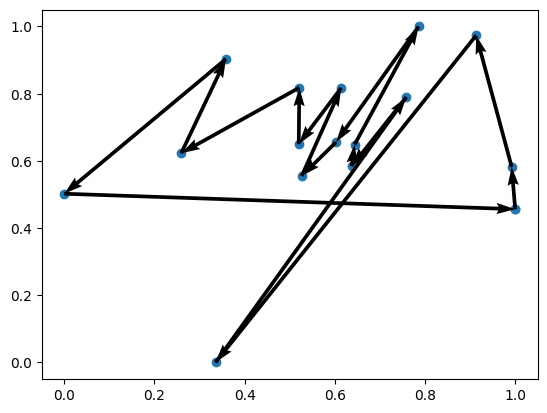

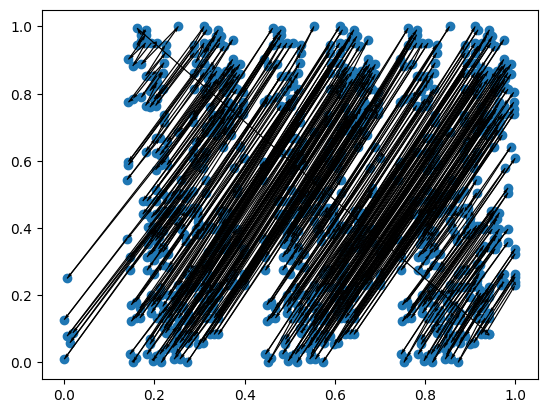

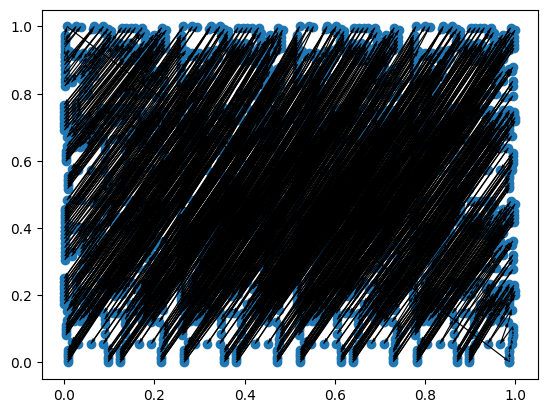

In [11]:
# Plot some instances
env.render(tds[0], actions[0].cpu())
env.render(tds[-2], actions[-2].cpu())
env.render(tds[-1], actions[-1].cpu())

### Train

We will train for few steps just to show the effects of training a model.
Alternatively, we can load the a pretrained checkpoint, e.g. with:

```python
model = AttentionModel.load_from_checkpoint(checkpoint_path, load_baseline=False)
```


In [ ]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None,
)

trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | TSPEnv     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


### Test trained model

In [13]:
tds, actions = [], []

policy = model.policy.eval().to(device)
for problem in problems:

    with torch.inference_mode():
        td_reset = env.reset(tsplib_to_td(problem)).to(device)
        out = policy(td_reset.clone(), env, decode_type = "greedy")
        unnormalized_td = env.reset(tsplib_to_td(problem, normalize=False)).to(device)
        cost = -env.get_reward(unnormalized_td, out["actions"]).item() # unnormalized cost
        
    bks_sol = (torch.tensor(problem['solution'], device=device, dtype=torch.int64) - 1)[None]
    bks_cost = -env.get_reward(unnormalized_td, bks_sol)
    
    tds.append(tsplib_to_td(problem))
    actions.append(out["actions"])
    
    gap = (cost - bks_cost.item()) / bks_cost.item()
            
    print(f"Problem: {problem['name']:<15} Cost: {cost:<14.4f} BKS: {bks_cost.item():<10.4f}\t Gap: {gap:.2%}")

/tmp/ipykernel_76573/1596842480.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coords = torch.tensor(problem['node_coords']).float()


Problem: ulysses16       Cost: 82.6168        BKS: 74.1087   	 Gap: 11.48%
Problem: ulysses22       Cost: 88.0642        BKS: 75.6651   	 Gap: 16.39%
Problem: att48           Cost: 39196.7305     BKS: 33523.7109	 Gap: 16.92%
Problem: eil51           Cost: 529.8539       BKS: 429.9833  	 Gap: 23.23%
Problem: berlin52        Cost: 9453.5234      BKS: 7544.3662 	 Gap: 25.31%
Problem: st70            Cost: 861.5684       BKS: 678.5975  	 Gap: 26.96%
Problem: pr76            Cost: 138428.1250    BKS: 108159.4375	 Gap: 27.99%
Problem: eil76           Cost: 673.4647       BKS: 545.3876  	 Gap: 23.48%
Problem: gr96            Cost: 633.9059       BKS: 512.3093  	 Gap: 23.74%
Problem: rd100           Cost: 10517.4844     BKS: 7910.3960 	 Gap: 32.96%
Problem: kroD100         Cost: 33366.3086     BKS: 21294.2930	 Gap: 56.69%
Problem: kroC100         Cost: 31602.7129     BKS: 20750.7617	 Gap: 52.30%
Problem: kroA100         Cost: 30531.9688     BKS: 21285.4414	 Gap: 43.44%
Problem: eil101         

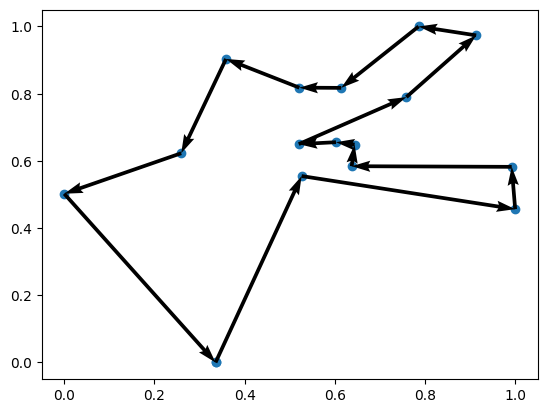

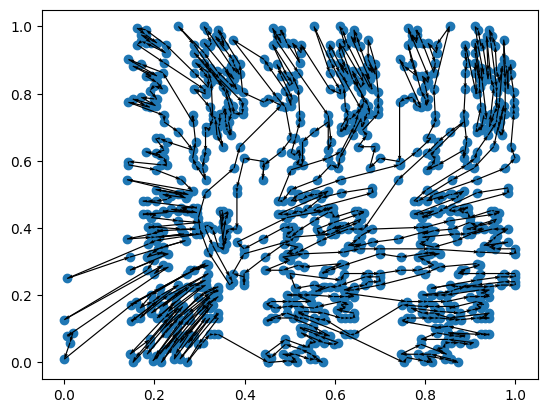

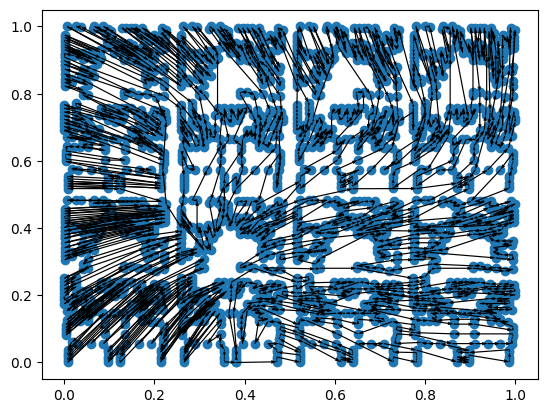

In [14]:
# Plot some instances
env.render(tds[0], actions[0].cpu())
env.render(tds[-2], actions[-2].cpu())
env.render(tds[-1], actions[-1].cpu())

Great! We can see that the performance vastly improved even with just few minutes of training.

There are several ways to improve the model's performance further, such as:
- Training for more steps
- Using a different model architecture
- Using a different training algorithm
- Using a different hyperparameters
- Using a different `Generator` 
- ... and many more!